In [1]:
import time
import torch
from torch import distributions as D
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm

In [2]:
# Hack to import from a parent directory
import sys, os
path = '..'
if path not in sys.path:
    sys.path.append(path)

from LogitNormal import *
from TruncatedNormal import *
from mean_field import *
from obs_and_flow_minibatch import *

## Generate data

Given fixed hyperparameters $\mu_\theta, \sigma_\theta, a, b, \mu_{x_0}, \sigma_x, \sigma_y$ and observed $y$, consider the following toy model:
- $\theta_0, \theta_1 \sim \text{LogitNormal}(\mu_\theta, \sigma_\theta, a, b)$
- $x_0 \sim N(\mu_{x_0}, \sigma_x)$
- $x_t \sim N(\theta_0+\theta_1x_{t-1}, \sigma_x)$
- $y_t \sim N(x_t, \sigma_y)$

We make simplifying assumptions that each state $x_t$ is one dimensional and every time step $y_t$ is observed. Our data consist of $N$ independent sequences of $y$.

In [3]:
def generate_data(N, T, dt, mu_theta, sigma_theta, a_theta, b_theta,
                  mu_x, sigma_x, sigma_y, obs_every=None, theta=None):
    torch.manual_seed(0)
    if obs_every is None:
        obs_every = dt
    #assert obs_every % dt == 0, 'obs_every must be divisible by dt'
    obs_every_step = int(obs_every / dt)
    
    # Sample theta
    p_theta = RescaledLogitNormal(mu_theta, sigma_theta, a=a_theta, b=b_theta)
    if theta is None:
        theta = p_theta.sample() # (2, )
    
    # Allocate x tensor
    M = int(T / dt) + 1
    x = torch.empty((N, M)) # N - number of independent sequences; M - length of each sequence
    
    # Sample x0
    p_x0 = D.normal.Normal(mu_x, sigma_x)
    x[:, 0] = p_x0.sample((N, )) # (N, )
    
    # Sample x_t, t > 0
    for i in range(1, M):
        p_xt = D.normal.Normal(theta[0] + theta[1] * x[:, i - 1], sigma_x)
        
        # Draw sample
        x[:, i] = p_xt.sample() # (N, )
    
    # Sample y
    x_for_y = x[:, ::obs_every_step]
    p_y = D.normal.Normal(x_for_y, sigma_y)
    y = p_y.sample() # (N, M_obs)
    
    # Observation timestamp t_y
    t_x = torch.arange(0, T + dt, dt)
    t_y = torch.arange(0, T + dt, obs_every)
    assert(len(t_y) == y.shape[1] and t_y[-1] == T)
    y_dict = {'t_y': t_y, 'y': y, 'sigma_y': sigma_y}
    
    return p_theta, theta, p_x0, x, y_dict

In [4]:
# theta hyperparameters
mu_theta = torch.tensor([0., 0.5])
sigma_theta = torch.tensor([1., 1.])
a_theta = torch.tensor([-2., -1.])
b_theta = torch.tensor([2., 1.])
theta = torch.tensor([0.6, 0.9])

# x hyperparameters
mu_x = torch.tensor(0.)
sigma_x = torch.tensor(0.8)

# y hyperparameter
sigma_y = torch.tensor(1.)

In [5]:
N, T, dt, obs_every = 1, 1000, 1.0, 10
p_theta, theta, p_x0, x, y_dict = generate_data(N, T, dt, mu_theta, sigma_theta, a_theta, b_theta,
                                                mu_x, sigma_x, sigma_y, obs_every=obs_every, theta=theta)

## Plot data

In [6]:
def plot_theta(p_theta, theta, num_pts=1000, eps=1e-6):
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
    
    a, b = p_theta.a, p_theta.b
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float()
    
    pdf_prior = torch.exp(p_theta.log_prob(theta_range)).detach()
    approx_int_prior = pdf_prior.sum(0) * (b - a) / num_pts
    assert torch.allclose(approx_int_prior, torch.tensor(1.0), rtol=1e-3)
    
    labels = ['$\\theta_0$', '$\\theta_1$']
    for i, ax in enumerate(axes):
        if i < 2:
            ax.plot(theta_range[:, i], pdf_prior[:, i], linewidth=2, label='prior')
            ax.axvline(theta[i], color='gray', label='true $\\theta$')
            ax.set_xlabel(labels[i])
            if i == 0: ax.set_ylabel('density')
        else:
            handles, labels = axes[0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center left')
            ax.axis('off')
    plt.tight_layout()

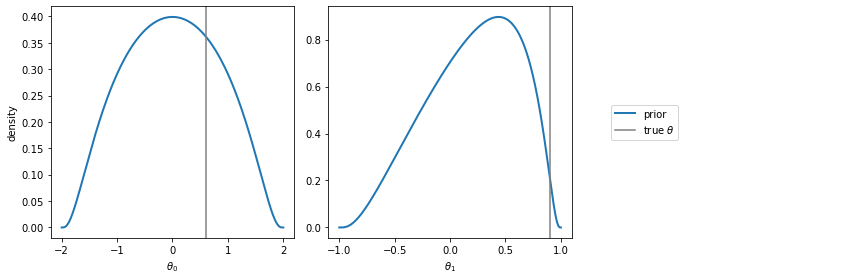

In [7]:
plot_theta(p_theta, theta)

In [8]:
def plot_path(x, y, t_x, t_y, title=None, state_dim=1):
    N, time_steps = x.shape
    fig, axes = plt.subplots(state_dim, figsize=(15, 4*state_dim), sharex=True)
    axes = np.atleast_1d(axes)
    
    for i, ax in enumerate(axes):            
        ax.plot(t_x, x[i, :], label='latent state')
        ax.plot(t_y, y[i, :], label='observation', linestyle='', marker='o')        
        ax.legend()
        if i == 0 and title:
            ax.set_title(title)
    ax.set_xlabel('hour')
    plt.tight_layout()

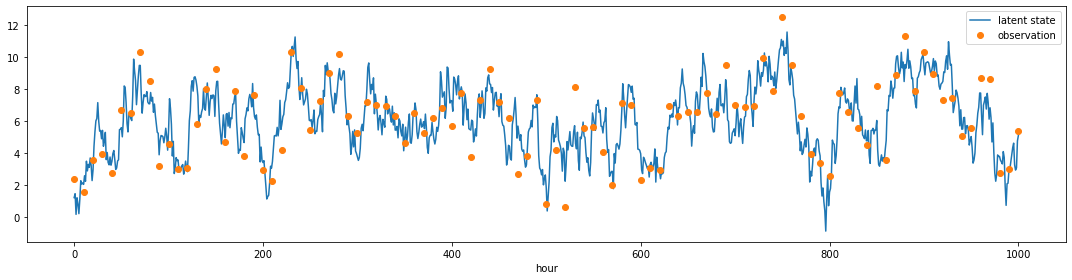

In [9]:
y, t_y = y_dict['y'], y_dict['t_y']
t_x = torch.arange(0, T + dt, dt)
plot_path(x, y, t_x, t_y)

## Inference

Objective:
$$
\begin{align}
\mathcal{L} &= \frac{1}{S} \sum_s \left[ \log p(\theta, x, y) - \log q(\theta, x|y) \right] \\
  &= \frac{1}{S} \sum_s \left[\log p(\theta^{(s)}) - \log q(x^{(s)}) + \frac{T}{M} \left( \log p(x^{(s)}|\theta^{(s)}) + \log p(y|x^{(s)}) - \log q(\theta^{(s)}) \right) \right]
\end{align}
$$
where $T$ is the total number of time steps and $M$ is the minibatch size.

In [10]:
active_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_printoptions(precision = 8)

# Neural SDE parameters
dt_flow = 1.0 # [1.0, 0.5]
M = int(T / dt_flow) + 1

# Theta info
theta_dist = 'RescaledLogitNormal' #String needs to be exact name of the distribution class. Other option is 'RescaledLogitNormal'.
theta_post_dist = 'MultivariateLogitNormal'
param_names = ['theta_0', 'theta_1']
theta_hyperparams = {k: (loc, scale, a, b) for k, loc, scale, a, b in zip(param_names, mu_theta, sigma_theta, a_theta, b_theta)}
target_hyperparams = {k: (mean, sd, a, b) for k, mean, sd, a, b in zip(param_names, p_theta.mean, p_theta.stddev, a_theta, b_theta)}
fix_theta_dict = {'sigma_x': sigma_x}

In [11]:
def calc_log_lik_minibatch(X, PARAMS_DICT, DT, X0_PRIOR, LIDX, RIDX):
    # X.shape == (batch_size, minibatch_size + 1, state_dim)
    theta0, theta1 = PARAMS_DICT['theta_0'].reshape(-1, 1, 1), PARAMS_DICT['theta_1'].reshape(-1, 1, 1)
    loc, scale = theta0 + theta1 * X[:, :-1, :], PARAMS_DICT['sigma_x'].reshape(1, 1, 1)
    p_x = D.normal.Normal(loc, scale) 
    
    # Compute log p(x|theta) = log p(x|x0, theta) + log p(x0|theta)
    ll = p_x.log_prob(X[:, 1:, :]).sum((-2, -1)) # log p(x|x0, theta)
    if LIDX == 0:
        ll += X0_PRIOR.log_prob(X[:, 0, :]).sum(-1) # log p(x0|theta)

    return ll # ll.shape == (batch_size, )

In [12]:
def train_minibatch(DEVICE, NET_LR: float, THETA_LR: float, ELBO_ITER: int, BATCH_SIZE: int,
        DATA: dict, T: float, DT: float, N: int,
        X0_PRIOR: torch.distributions.distribution.Distribution,
        PRIOR_DIST_DETAILS_DICT: dict, 
        THETA_DIST = None, THETA_POST_DIST = None, THETA_POST_INIT = None,
        ELBO_LR_DECAY: float = 0.8, ELBO_DECAY_STEP_SIZE: int = 50000, 
        PRINT_EVERY: int = 100, MINIBATCH_T: int = 0, FIX_THETA_DICT: dict = None,
        NUM_LAYERS: int = 5, KERNEL_SIZE: int = 3, NUM_RESBLOCKS: int = 2,
        THETA_COND = 'convolution', CALC_FULL_LOSS_EVERY = 0, REVERSE: bool = False):
    torch.manual_seed(seed)
    print('seed', seed)
    obs_dim, state_dim = 1, 1
    
    #Read in data to obtain y and establish observation model.
    obs_times, obs_vals, obs_error = DATA['t_y'], DATA['y'], DATA['sigma_y']
    obs_model_minibatch = ObsModelMinibatch(TIMES = obs_times, DT = DT, MU = obs_vals, SCALE = obs_error).to(DEVICE)

    #Establish neural network.
    net = SDEFlowMinibatch(DEVICE, obs_model_minibatch, state_dim, T, N, len(PRIOR_DIST_DETAILS_DICT), OTHER_INPUTS = None, FIX_THETA_DICT = FIX_THETA_DICT,
            NUM_LAYERS = NUM_LAYERS, KERNEL_SIZE = KERNEL_SIZE, NUM_RESBLOCKS = NUM_RESBLOCKS, THETA_COND = THETA_COND, POSITIVE = False, REVERSE = REVERSE)
    
    param_names = list(PRIOR_DIST_DETAILS_DICT.keys())

    #Convert prior details dictionary values to tensors.
    prior_list = list(zip(*(PRIOR_DIST_DETAILS_DICT[k] for k in param_names))) #Unzip prior distribution details from dictionary values into individual lists.
    prior_means_tensor, prior_sds_tensor, prior_lowers_tensor, prior_uppers_tensor = torch.tensor(prior_list).to(DEVICE) #Ensure conversion of lists into tensors.

    #Retrieve desired distribution class based on string.
    dist_class_dict = {
            'TruncatedNormal': TruncatedNormal,
            'RescaledLogitNormal': RescaledLogitNormal,
            'MultivariateLogitNormal': MultivariateLogitNormal
            }
    THETA_PRIOR_CLASS = dist_class_dict[THETA_DIST]
    THETA_POST_CLASS = dist_class_dict[THETA_POST_DIST] if THETA_POST_DIST else dist_class_dict[THETA_DIST]
    
    #Define prior
    p_theta = THETA_PRIOR_CLASS(loc = prior_means_tensor, scale = prior_sds_tensor, a = prior_lowers_tensor, b = prior_uppers_tensor)

    # Initialize posterior q(theta) using its prior p(theta)
    learn_cov = (THETA_POST_DIST == 'MultivariateLogitNormal')
    if THETA_POST_INIT is None:
        THETA_POST_INIT = PRIOR_DIST_DETAILS_DICT
    q_theta = MeanField(DEVICE, param_names, THETA_POST_INIT, THETA_POST_CLASS, learn_cov)

    #Record loss throughout training
    #best_loss_norm = 1e15
    #best_loss_ELBO = 1e15
    #norm_losses = []
    ELBO_losses = []
    losses_full = []
    means_hist = []
    sds_hist = []

    #Initiate optimizers.
    #ELBO_params = list(net.parameters()) + list(q_theta.parameters())
    #ELBO_optimizer = optim.Adamax(ELBO_params, lr = ELBO_LR)
    net_optimizer = optim.Adamax(net.parameters(), lr = NET_LR)
    theta_optimizer = optim.Adamax(q_theta.parameters(), lr = THETA_LR)

    # Sample minibatch indices
    minibatch_size = int(MINIBATCH_T / DT)
    if 0 < minibatch_size < N and T % MINIBATCH_T == 0:
        minibatch_indices = torch.arange(0, N - minibatch_size, minibatch_size) + 1
        rand = torch.randint(len(minibatch_indices), (ELBO_ITER + 1, ))
        batch_indices = minibatch_indices[rand]
        print(f'Time series being chunked into {len(minibatch_indices)} minibatches at time step indices {minibatch_indices}. Check that this is the intended minibatch size.')

        # Print warning unless each minibatch is used at least once
        if torch.min(torch.bincount(rand)) == 0:
            print('Warning: Not all minibatches are used at least once.')
    else:
        # If minibatch_size is outside of acceptable range, then use full batch by default
        print('Proceeding with uni-batching, because either minibatch_size >= N, or T % MINIBATCH_T != 0.')
        batch_indices = None
        
    # Compute initial (0th iteration) ELBO
    if CALC_FULL_LOSS_EVERY > 0:
        print('HERE')
        with torch.no_grad():
            # Sample (unknown) theta ~ q(theta) and compute log q(theta)
            theta_dict, theta, log_q_theta, parent_loc_scale_dict = q_theta(BATCH_SIZE)
            
            # Compute log p(theta)
            log_p_theta = p_theta.log_prob(theta).sum(-1)
            
            # Fix known theta
            if FIX_THETA_DICT:
                theta_dict = {**theta_dict, **FIX_THETA_DICT}
    
            # Sample x and compute log q(x)    
            lidx_full, ridx_full = 0, N
            C_PATH_full, log_prob_full = net(BATCH_SIZE, lidx_full, ridx_full, theta = theta)
            log_prob_full = log_prob_full.sum((-1, -2))
            #assert (log_prob_full.shape == (BATCH_SIZE, ))
            
            log_lik_full = calc_log_lik_minibatch(C_PATH_full, theta_dict, DT, X0_PRIOR, lidx_full, ridx_full)
            #assert (log_lik_full.shape == (BATCH_SIZE, ))
            
            log_p_obs_full = obs_model_minibatch(C_PATH_full, theta_dict, lidx_full, ridx_full)
            #assert (log_p_obs_full.shape == (BATCH_SIZE, ))
            
            loss_full = -log_p_theta.mean() + log_q_theta.mean() + log_prob_full.mean() - log_lik_full.mean() - log_p_obs_full.mean()
            print(-log_p_theta.mean().item(), log_q_theta.mean().item(), log_prob_full.mean().item(), log_lik_full.mean().item(), log_p_obs_full.mean().item())
            
            losses_full.append(loss_full.item())
            print('Iteration 0 full loss: {}'.format(loss_full.item()))
        
    #Training loop
    net.train()
    with tqdm(total = ELBO_ITER, desc = f'Learning SDE and hidden parameters.', position = -1) as tq:
        for it in range(ELBO_ITER + 1):
            net_optimizer.zero_grad()
            theta_optimizer.zero_grad()
            
            # Sample (unknown) theta ~ q(theta) and compute log q(theta)
            theta_dict, theta, log_q_theta, parent_loc_scale_dict = q_theta(BATCH_SIZE)
            
            # Compute log p(theta)
            log_p_theta = p_theta.log_prob(theta).sum(-1)
            
            # Fix known theta
            if FIX_THETA_DICT:
                theta_dict = {**theta_dict, **FIX_THETA_DICT}
            
            # Sample x_{u-1:v}|y, theta (unless u = 0, then sample x_{u:v})
            if batch_indices is not None:
                lidx = max(0, batch_indices[it] - 1)              # u-1 if u > 0, else 0
                ridx = min(N, batch_indices[it] + minibatch_size) # v
            else:
                lidx, ridx = 0, N
            C_PATH, log_prob = net(BATCH_SIZE, lidx, ridx, theta = theta) # (batch_size, minibatch_size+1, state_dim)
            
            # Compute log q(x_{u:v}|theta) (exclude u-1 unless lidx = 0)
            if lidx == 0:
                log_prob = log_prob.sum((-1, -2)) # (batch_size, )
            else:
                log_prob = log_prob[:, 1:, :].sum((-1, -2))
            #assert (log_prob.shape == (BATCH_SIZE, ))
            
            # Compute conditional log p(x_{u:v}|x_{u-1}, theta) (if lidx = 0, joint log p(x_{0:v}, theta))
            log_lik = calc_log_lik_minibatch(C_PATH, theta_dict, DT, X0_PRIOR, lidx, ridx)
            #assert (log_lik.shape == (BATCH_SIZE, ))
            
            # Compute log p(x_{u:v}|y_{u:v})
            log_p_obs = obs_model_minibatch(C_PATH, theta_dict, lidx, ridx)
            #assert (log_p_obs.shape == (BATCH_SIZE, ))
    
            # Compute negative ELBO loss
            # If lidx == 0: -log p(theta) + log q(theta) + N/M * (log q(x_{0:v}|theta) - log p(x_{0:v}, theta) - log p(y_{0:v}|x_{0:v}, theta))
            # else: -log p(theta) + log q(theta) + N/M * (log q(x_{u:v}|theta) - log p(x_{u:v}|x_{u-1}, theta) - log p(y_{u:v}|x_{u:v}, theta))
            active_minibatch_size = minibatch_size + 1 if lidx == 0 else minibatch_size
            #print(lidx, ridx, N, active_minibatch_size)
            ELBO = -log_p_theta.mean() + log_q_theta.mean() + N/active_minibatch_size * (log_prob.mean() - log_lik.mean() - log_p_obs.mean())
            #print(log_p_theta.mean(), log_q_theta.mean(), log_prob.mean(), log_lik.mean(), log_p_obs.mean())
            
            # Record (minibatch) loss
            ELBO_losses.append(ELBO.item())
            #print(ELBO.item())
            
            if it % PRINT_EVERY == 0:
                print('Iteration {} minibatch loss: {}'.format(it, ELBO_losses[-1]))
            
            if it < ELBO_ITER:
                # Take gradient step
                ELBO.backward()
                torch.nn.utils.clip_grad_norm_(net.parameters(), 5.0)
                torch.nn.utils.clip_grad_norm_(q_theta.parameters(), 5.0)
                net_optimizer.step()
                theta_optimizer.step()
                
                # Record full loss
                calc_full_loss = CALC_FULL_LOSS_EVERY > 0 and (it + 1) % CALC_FULL_LOSS_EVERY == 0
                if calc_full_loss:
                    with torch.no_grad():
                        lidx_full, ridx_full = 0, N
                        C_PATH_full, log_prob_full = net(BATCH_SIZE, lidx_full, ridx_full, theta = theta)
                        log_prob_full = log_prob_full.sum((-1, -2))
                        #assert (log_prob_full.shape == (BATCH_SIZE, ))
                        
                        log_lik_full = calc_log_lik_minibatch(C_PATH_full, theta_dict, DT, X0_PRIOR, lidx_full, ridx_full)
                        #assert (log_lik_full.shape == (BATCH_SIZE, ))
                        
                        log_p_obs_full = obs_model_minibatch(C_PATH_full, theta_dict, lidx_full, ridx_full)
                        #assert (log_p_obs_full.shape == (BATCH_SIZE, ))
                        
                        loss_full = -log_p_theta.mean() + log_q_theta.mean() + log_prob_full.mean() - log_lik_full.mean() - log_p_obs_full.mean()
                        losses_full.append(loss_full.item())
                        
                        if (it + 1) % PRINT_EVERY == 0:
                            print('Iteration {} full loss: {}'.format(it + 1, loss_full.item()))
                       
            if ELBO_ITER - (1000 * (T // minibatch_size)) <= it < ELBO_ITER:
                # Record theta parameter values
                means_hist.append(torch.clone(q_theta.means))
                sds_hist.append(torch.clone(q_theta.sds))
            
            # Update learning rate
            if it > 0 and it % ELBO_DECAY_STEP_SIZE == 0:
                net_optimizer.param_groups[0]['lr'] *= ELBO_LR_DECAY
                theta_optimizer.param_groups[0]['lr'] *= ELBO_LR_DECAY
                print('Dropped learning rate to:', net_optimizer.param_groups[0]['lr'], theta_optimizer.param_groups[0]['lr'])
                
            tq.update()

    print('\nAll finished! Now, we need to check outputs to see if things worked...')
    
    return net, q_theta, p_theta, obs_model_minibatch, ELBO_losses, losses_full, means_hist, sds_hist #, times

In [13]:
#Training parameters
niter = 30000 # niter = epochs * (m - 1) / minibatch_size
net_lr, theta_lr = 0.01, 0.01 #ELBO learning rate
batch_size = 20 #3 - number needed to fit UCI HPC3 RAM requirements with 16 GB RAM at t = 5000.
minibatch_size = 100
seed = 1

In [14]:
net_rev, q_theta_raw_rev, p_theta_rev, obs_model_rev, losses_mini_rev, losses_rev, means_rev, sds_rev = train_minibatch(
    active_device, 0.01, 0.01, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 0.1, ELBO_DECAY_STEP_SIZE = 10000, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False, CALC_FULL_LOSS_EVERY = 3*T // minibatch_size, REVERSE = True)

seed 1
Time series being chunked into 10 minibatches at time step indices tensor([  1, 101, 201, 301, 401, 501, 601, 701, 801, 901]). Check that this is the intended minibatch size.
HERE
1.8063433170318604 -1.8063433170318604 -1792.7884521484375 -3447.19921875 -2340.063720703125
Iteration 0 full loss: 3994.474609375


Iteration 0 minibatch loss: 4073.96630859375



ValueError: The parameter loc has invalid values

In [ ]:
net_high_decay, q_theta_raw_high_decay, p_theta_high_decay, obs_model_high_decay, losses_mini_high_decay, losses_high_decay, means_high_decay, sds_high_decay = train_minibatch(
    active_device, 0.01, 0.01, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 0.1, ELBO_DECAY_STEP_SIZE = 10000, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False, CALC_FULL_LOSS_EVERY = 3*T // minibatch_size)

In [ ]:
net_conv, q_theta_raw_conv, p_theta_conv, obs_model_conv, losses_mini_conv, losses_conv, means_conv, sds_conv = train_minibatch(
    active_device, 0.01, 0.01, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 0.1, ELBO_DECAY_STEP_SIZE = 10000, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = 'convolution', CALC_FULL_LOSS_EVERY = 3*T // minibatch_size)

In [ ]:
net_linear, q_theta_raw_linear, p_theta_linear, obs_model_linear, losses_mini_linear, losses_linear, means_linear, sds_linear = train_minibatch(
    active_device, 0.01, 0.01, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 0.1, ELBO_DECAY_STEP_SIZE = 10000, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = 'linear', CALC_FULL_LOSS_EVERY = 3*T // minibatch_size)

In [ ]:
net_conv.window, net_conv.num_layers, net_high_decay.window, net_high_decay.num_layers

In [ ]:
net_conv.layers[0].window, net_conv.layers[0].network[0], net_conv.layers[0].network[1], net_conv.layers[0].network[2]

In [ ]:
net_conv.layers[0].network[0].window, net_conv.layers[0].network[1].window, net_conv.layers[0].network[2]

In [ ]:
# Lower lr, smaller sample size, longer iterations
net_high, q_theta_raw_high, p_theta_high, obs_model_high, losses_mini_high, losses_high = train_minibatch(
    active_device, net_lr, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False, CALC_FULL_LOSS_EVERY = 3*T // minibatch_size)

In [ ]:
len(losses_high)

In [ ]:
net_low, q_theta_raw_low, p_theta_low, obs_model_low, losses_mini_low, losses_low = train_minibatch(
    active_device, 0.001, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False, CALC_FULL_LOSS_EVERY = 3*T // minibatch_size)

In [ ]:
# Lower lr, smaller sample size, longer iterations
niter = 20000
net_high, q_theta_raw_high, p_theta_high, obs_model_high, losses_mini_high, losses_high = train_minibatch(
    active_device, 0.01, 0.01, niter, 20,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False, CALC_FULL_LOSS_EVERY = T // minibatch_size)

In [ ]:
iters_per_epoch = T // minibatch_size
epochs = niter/iters_per_epoch
print(iters_per_epoch, epochs)

In [ ]:
T / minibatch_size, M

In [ ]:
net_no, q_theta_raw_no, p_theta_no, obs_model_no, losses_mini_no, losses_no = train_minibatch(
    active_device, net_lr, theta_lr, 10, 20,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False, CALC_FULL_LOSS_EVERY = T // minibatch_size)

In [ ]:
net_no_low, q_theta_raw_no_low, p_theta_no_low, obs_model_no_low, losses_mini_no_low, losses_no_low = train_minibatch(
    active_device, net_lr, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist, THETA_POST_INIT = target_hyperparams,
    MINIBATCH_T = M, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = False, CALC_FULL_LOSS_EVERY = 0)

In [ ]:
net_no_low, q_theta_raw_no_low, p_theta_no_low, obs_model_no_low, losses_mini_no_low, losses_no_low = train_minibatch(
    active_device, net_lr, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist, THETA_POST_INIT = target_hyperparams,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 0.9, ELBO_DECAY_STEP_SIZE = niter // 10,
    PRINT_EVERY = max(1, niter // 10), FIX_THETA_DICT = fix_theta_dict, THETA_COND = False, CALC_FULL_LOSS_EVERY = T // minibatch_size)

In [ ]:
net_conv, q_theta_raw_conv, p_theta_conv, obs_model_conv, losses_mini_conv, losses_conv = train_minibatch(
    active_device, net_lr, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist, THETA_POST_INIT = target_hyperparams,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = 'convolution', CALC_FULL_LOSS_EVERY = T // minibatch_size)

In [ ]:
net_linear, q_theta_raw_linear, p_theta_linear, obs_model_linear, losses_mini_linear, losses_linear = train_minibatch(
    active_device, net_lr, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist, THETA_POST_INIT = target_hyperparams,
    MINIBATCH_T = minibatch_size, ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, THETA_COND = 'linear', CALC_FULL_LOSS_EVERY = T // minibatch_size)

In [ ]:
def plot_loss(loss_hist_list, labels, time_hist_list=None, xscale='linear', ymin=None, ymax=None):
    plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2, 'figure.figsize': (8, 6)})
    
    colors = [cm.tab10(i+1) for i in range(len(labels))]
    for loss_hist, label, color in zip(loss_hist_list, labels, colors):
        plt.plot(loss_hist, label=label, color=color)
    
    plt.title('Loss v epoch')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.xscale(xscale)
    plt.ylim((ymin, ymax))

In [ ]:
labels = ['no theta conditioning', 'convolution', 'linear'] #labels = ['full-rank', 'mean-field']
plot_loss([losses_high_decay, losses_conv, losses_linear], labels, ymax=700, ymin=100) # 

In [ ]:
labels = ['no theta conditioning', 'lower'] #labels = ['full-rank', 'mean-field']
plot_loss([losses_no, losses_no_low], labels, ymax=550, ymin=510) # 

In [ ]:
labels = ['convolution theta conditioning', 'linear theta conditioning', 'no theta conditioning'] #labels = ['full-rank', 'mean-field']
plot_loss([losses_conv, losses_linear, losses_no], labels, ymax=700, ymin=500) # 

In [ ]:
# Extracts the distribution from a MeanField object
def extract_dist(q):
    a, b = q.lowers, q.uppers
    loc = q.means
    if not q.learn_cov:
        scale = torch.max(q.sds, torch.ones_like(q.sds) * 1e-8)
        #scale = D.transform_to(q.dist.arg_constraints['scale'])(q.sds)
        return q.dist(loc, scale=scale, a=a, b=b)
    else:
        scale = D.transform_to(q.dist.arg_constraints['scale_tril'])(q.sds)
        return q.dist(loc, scale_tril=scale, a=a, b=b)

In [ ]:
q_theta_low = extract_dist(q_theta_raw_low)
q_theta_high = extract_dist(q_theta_raw_high)

In [ ]:
def plot_theta_post(p_theta, q_theta_list, theta_samples, labels, num_pts=1000, eps=1e-6):
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
    
    a, b = p_theta.a, p_theta.b
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float()
    
    pdf_prior = torch.exp(p_theta.log_prob(theta_range)).detach()
    approx_int_prior = pdf_prior.sum(0) * (b - a) / num_pts
    assert torch.allclose(approx_int_prior, torch.tensor(1.0), rtol=1e-3)
    
    # Load marginal posteriors
    pdf_post_list = []
    for q_theta in q_theta_list:
        if isinstance(q_theta, MultivariateLogitNormal):
            scale_post = torch.diag(q_theta.covariance_matrix).sqrt()
            q_marginal = RescaledLogitNormal(q_theta.loc, scale_post, a=a, b=b)
        else:
            q_marginal = q_theta
        pdf_post = torch.exp(q_marginal.log_prob(theta_range)).detach()
        pdf_post_list.append(pdf_post)
    
    param_names = ['$\\theta_0$', '$\\theta_1$']
    colors = [cm.tab10(i+1) for i in range(len(q_theta_list))]
    for i, ax in enumerate(axes):
        if i < 2:
            ax.plot(theta_range[:, i], pdf_prior[:, i], linewidth=2, label='prior')
            ax.axvline(theta[i], color='gray', label='true $\\theta$')
            for pdf_post, post_dist, c in zip(pdf_post_list, labels, colors):
                label = 'posterior {}'.format(post_dist)
                ax.plot(theta_range[:, i], pdf_post[:, i], label=label, color=c)
                    
            ax.set_xlabel(param_names[i])
            if i == 0: ax.set_ylabel('density')
        else:
            handles, labels = axes[0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center left')
            ax.axis('off')
    plt.tight_layout()
    pass

In [ ]:
plot_theta_post(p_theta, [q_theta_low, q_theta_high], theta, labels)

In [ ]:
def plot_path_post(net_list, T, dt, y, t_y, theta=None, q_theta_raw_list=None, labels=None,
                   title=None, state_dim=1, batch_size=30, summarize=False, alg_list=None, colors=None, linestyles=None,
                   plot_lidx=0, plot_ridx=None):
    # algs: 0 - old net, 1 - new net, 2 - kf
    if alg_list is None:
        alg_list = [1] * len(net_list)
    if colors is None:
        colors = [cm.tab10(i+1) for i in range(len(labels))]
    if linestyles is None:
        linestyles = ['-'] * len(labels)
    
    #N, time_steps = x.shape
    times = torch.tensor(np.arange(0, T + dt, dt))
    fig, axes = plt.subplots(state_dim, figsize=(15, 4*state_dim), sharex=True)
    axes = np.atleast_1d(axes)
    
    # Draw theta
    if theta is None:
        assert q_theta_raw_list is not None
        theta_list = []
        for i, q_theta_raw in enumerate(q_theta_raw_list):
            if q_theta_raw is not None:
                _, theta, _, _ = q_theta_raw(batch_size)
            else:
                assert alg_list[i] != 1 or net_list[i].theta_cond is False
                theta = None
            theta_list.append(theta)
    else:
        if q_theta_raw_list is not None:
            print('Using provided theta, ignoring q_theta')
    
    
    M = int(T / dt) + 1
    x_list = []
    for net, theta, alg in zip(net_list, theta_list, alg_list):
        if alg == 1 and net.theta_cond is False:
            assert theta is None
        if alg == 0:
            net.eval()
            x = net(batch_size)[0].detach()
        elif alg == 1:
            net.eval()
            x = net(batch_size, 0, M, theta=theta)[0].detach()
        else:
            x = net
        x_list.append(x)
    
    for i, ax in enumerate(axes):            
        #ax.plot(t_x, x[i, :], label='latent state')
        for x, label, color, l, alg in zip(x_list, labels, colors, linestyles, alg_list):
            if summarize:
                if alg < 2:
                    net_left, net_center, net_right = torch.quantile(x[:, :, i], torch.tensor([0.025, 0.5, 0.975]), dim=0)
                else:
                    net_center = x.mu_smooth[:, i]
                    sd_smooth = x.sigma_smooth[:, i, i].sqrt()
                    net_left, net_right = net_center - 2*sd_smooth, net_center + 2*sd_smooth
                
                #label_str = 'state {}'.format(label)
                ax.plot(times[plot_lidx:plot_ridx], net_center[plot_lidx:plot_ridx], label = label, color=color, linestyle=l)
                ax.fill_between(times[plot_lidx:plot_ridx], net_left[plot_lidx:plot_ridx], net_right[plot_lidx:plot_ridx],
                                alpha = 0.4, color=color) #, label = 'state 2.5-97.5%'
            else:
                for j in range(batch_size):
                    label_str = 'state {}'.format(label) if j == 0 else None
                    ax.plot(times[plot_lidx:plot_ridx], x[j, [plot_lidx:plot_ridx], i], label=label_str, color=color)
        
        y_lidx, y_ridx
        ax.plot(t_y, y[i, :], label='observation', linestyle='', marker='o', color=cm.tab10(0))
        ax.legend()
        if i == 0 and title:
            ax.set_title(title)
    ax.set_xlabel('hour')
    plt.tight_layout()

In [ ]:
plot_path_post(net, T, dt_flow, y, t_y, theta=theta.repeat(batch_size, 1), eval_batch_size=batch_size)

In [ ]:
plot_path_post([net_low, net_high], T, dt_flow, y, t_y, q_theta_raw_list=[None, None],
               batch_size=batch_size, labels=labels)

## Save results

In [ ]:
save_dir = 'data/toy_ssm1'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
loss_file = '{}/new_mini_no_loss.pt'.format(save_dir)
net_file = '{}/new_mini_no_net.pt'.format(save_dir)
q_raw_file = '{}/new_mini_no_q_raw.pt'.format(save_dir)
torch.save([losses_low, losses_high, losses_high_decay], loss_file) # , losses_trunc_mf
torch.save([net_low, net_high, net_high_decay], net_file)
torch.save([q_theta_raw_low, q_theta_raw_high, q_theta_raw_high_decay], q_raw_file) # , q_theta_trunc_mf
#torch.save([times, times_mf], time_file) # , times_trunc_mf

In [ ]:
loss_file = '{}/new_mini_loss.pt'.format(save_dir)
net_file = '{}/new_mini_net.pt'.format(save_dir)
q_raw_file = '{}/new_mini_q_raw.pt'.format(save_dir)
q_hist_file = '{}/new_mini_q_hist.pt'.format(save_dir)
torch.save([losses_high_decay, losses_conv, losses_linear], loss_file) # , losses_trunc_mf
torch.save([net_high_decay, net_conv, net_linear], net_file)
torch.save([q_theta_raw_high_decay, q_theta_raw_conv, q_theta_raw_linear], q_raw_file) # , q_theta_trunc_mf
torch.save([(means_high_decay, sds_high_decay), (means_conv, sds_conv), (means_linear, sds_linear)], q_hist_file) # , times_trunc_mf

In [ ]:
q_hist_file = '{}/new_mini_no_q_hist.pt'.format(save_dir)
torch.save([means_high_decay, sds_high_decay], q_hist_file)

## Archive
Consider a simplified transition distribution given by:
$$ \mathbf{x}_t = \mathbf{A}_t \mathbf{x}_{t-1} + \boldsymbol{\epsilon}_t$$

where $\boldsymbol{\epsilon}_t \sim N(\mathbf{0}, \mathbf{Q}_t)$ is a Gaussian system noise.

$x_t \sim \text{MultivariateNormal}(A_tx_{t-1}, Q_t)$

For simplicity, let A = diag(\theta), Q is known. Should we do 1 state dim?

In [ ]:
a = torch.empty(2, 3, 1)
a[:, :-1, :]

In [ ]:
a.shape

In [ ]:
base_dist = D.normal.Normal(loc = 0., scale = LowerBound.apply(self.scale, 1e-6))
        eps = base_dist.sample([bsz, self.state_dim * self.n]).to(self.device)
        log_prob = base_dist.log_prob(eps).permute(0, 2, 1)[:, :, active_lidx:active_ridx]

In [ ]:
base = D.normal.Normal(0., torch.tensor([1.]))
eps = base.sample((2, 5))
log_prob = base.log_prob(eps)
log_prob.permute(0, 2, 1).shape

In [ ]:
a = torch.arange(6).reshape((2, 3))
a

In [ ]:
perm_idx = torch.randperm(3)
rev_idx = torch.arange(1, -1, -1)
perm_idx, rev_idx

In [ ]:
a[rev_idx, :][:, perm_idx]

In [ ]:
a.flip(0)[:, perm_idx]

In [ ]:
a[::-1, perm_idx]